# FF Weight-Matrix Variation
Purpose:
- To demonstrate that a FF network trained using BP can produce a variety of different weight matrices.
- We start with a bunch of random inial weights, and train the network.
- Then we look at all the resulting weight matrices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
#importlib.reload(NN)
importlib.reload(FF)
importlib.reload(Layer);

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

In [3]:
def cosine_proximity(M1, M2):
    return np.sum(M1*M2) / np.linalg.norm(M1.flatten()) / np.linalg.norm(M2.flatten())

## Create a simple dataset

In [4]:
# This creates a dataset

n_classes = 3
#hidden_dim = 5
sensory_dim = 5

seed = 2610
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-0.48932516  0.13014042  1.4684664   0.48737025  0.72496988]
 [-1.2323579  -1.16497735  0.56182042 -1.46463011  0.16859907]
 [-1.22924953 -0.43436831  1.13980164 -1.40424674 -0.86098236]]


In [5]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2, seed=None):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    if seed!=None:
        np.random.seed(seed)
    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [6]:
train = MakeDataset(A, B, noise=0.2)

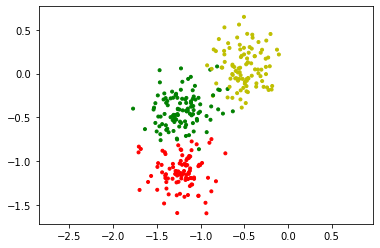

In [7]:
ClassPlot(train[1], labels=train[0], idx=(0,1))

## Create a Simple Network

In [10]:
lr = 0.01   # learning rate
Wdecay = 0.0007  # weight decay
af = 'identity'
mid_af = 'logistic'

In [11]:
# Create a network
ffnet = FF.Network()
ffnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
#ffnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=mid_af))
ffnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))
ffnet.SetCostFunction('MSE')

## Train it with and without weight decay...

### Without weight decay

In [12]:
# Train a bunch, and record the weight matrices
# One trial's matrix in each col
n_trials = 10
Ws = []
total_accuracy = 0.
for trial in range(n_trials):
    ffnet.RandomWeights(mult=4.)
    ffnet.SGD(train[1].numpy(), train[0].numpy(), lrate=lr, epochs=500, batch_size=30, decay=0., progress=1000)
    total_accuracy += FF.ClassificationAccuracy(ffnet.FeedForward(train[1].numpy()), train[0].numpy())
    Ws.append(ffnet.W[0].flatten())
Ws = np.array(Ws).T
print('Accuracy = '+str(np.round(total_accuracy/n_trials*100, 2))+'%')

Accuracy = 100.0%


### WITH weight decay

In [13]:
# Train a bunch, and record the weight matrices
# One trial's matrix in each col
n_trials = 10
Ws_decay = []
total_accuracy = 0.
for trial in range(n_trials):
    ffnet.RandomWeights(mult=4.)
    ffnet.SGD(train[1].numpy(), train[0].numpy(), lrate=lr, epochs=500, batch_size=30, decay=Wdecay, progress=1000)
    total_accuracy += FF.ClassificationAccuracy(ffnet.FeedForward(train[1].numpy()), train[0].numpy())
    Ws_decay.append(ffnet.W[0].flatten())
Ws_decay = np.array(Ws_decay).T
print('Accuracy = '+str(np.round(total_accuracy/n_trials*100, 2))+'%')

Accuracy = 100.0%


## Let's look at how similar the weight matrices are.

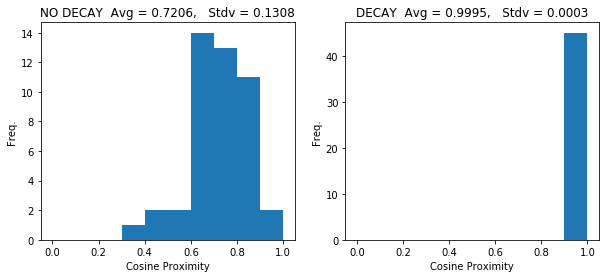

In [15]:
# Statistics of Cosine Proximity
titles = ['NO DECAY', 'DECAY']
plt.figure(figsize=(10,4))
for k,blah in enumerate([Ws, Ws_decay]):
    cp = []
    WsT = blah.T
    for i,w1 in enumerate(WsT):
        for j,w2 in enumerate(WsT[i+1:]):
            cp.append(cosine_proximity(w1,w2))
    cp = np.array(cp)

    plt.subplot(1,2,k+1)
    plt.hist(cp, range=[0,1]);
    plt.xlabel('Cosine Proximity'); plt.ylabel('Freq.');
    plt.title(titles[k]+'  Avg = '+str(np.round(np.mean(cp),4))+',   Stdv = '+str(np.round(np.std(cp),4)))
